# Recommender System

Recommender systems are among the most popular applications of data science today. Our target in Recommendation process is to predict the "rating" or "preference" that a user would give to an item. There are many tech-companies that have already applied them in practice use.
* Amazon uses it to suggest products to customers
* YouTube uses it to decide which video to play next on autoplay
* Facebook uses it to recommend pages to like and people to follow
* ...

Generally speaking, Recommender System can be classified into 3 types:
* Popularity-based recommender
* Content-based recommender
* Collaborative filtering (CF) recommender
    * model-based
    * memory-based

In this project, we will focus on the last two recommenders. For content-based and memory-based CF, we will build on our own. For model-based CF, we are going to use Python package [`surprise`](https://surprise.readthedocs.io/en/stable/getting_started.html#). Please install `surprise` before using it. 

Now let's import some packages and read the data we have processed before. 

In [1]:
# import packages

import pandas as pd
import numpy as np

from scipy import sparse
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

# skip all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = pd.read_csv("../data/last_1_years_restaurant_reviews.csv")
df.head(3)

,business_id,name,categories,avg_stars,cool,date,funny,review_id,stars,text,useful,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Cajun/Creole, Seafood, Steakhouses, Restaurants",4.0,0,2018-05-08 16:39:25,0,tTD3wegtsiHOjVTLgsb7FA,5.0,On yelp 5 stars = Woohoo! as good as it gets! ...,0,joe4i-lcCFd2wViA2agGKw
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Cajun/Creole, Seafood, Steakhouses, Restaurants",4.0,0,2018-06-19 23:47:56,0,aie6cd-6-nbQ5SOMgfSteg,5.0,Excellent food and service!! Everyone enjoyed ...,0,CW2rG0leS6vuVHLyvUx4Cg
2,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"Cajun/Creole, Seafood, Steakhouses, Restaurants",4.0,0,2018-04-05 00:49:01,0,HGegJEZMSilsyt7RNcxwCw,5.0,We had a great experience! Super friendly and...,0,hOQ70lGgr6hYRMcoS330Kw


In [3]:
df.shape

(188988, 12)

# Content-based Recommender

In this section, we will implement a content-based recommender system, which is based on features of the item. Here, the item is Restaurant (`business_id`) and features include average rating, cool, useful and text information. We will group by business_id to compute those score-related features. For text info, we use simple NLP techniques to generate word-like features. This will give you a high dimension feature space. Therefore, you should also need to perform Dimensionality Reduction.

## Feature Engineering

In this subsection, we generate some useful features.

In [4]:
# group by business_id, then average numerical features
df_average = df.groupby(['business_id']).mean()

# group by business_id, extract categories data
categories_series = df.groupby(['business_id']).categories.apply(np.unique)

# convert categories data to string remove `[]`
categories_series = categories_series.str.join('').apply(lambda x: x[1:-1])

# business_id, categories table
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
categories_mat = vectorizer.fit_transform(categories_series).toarray()
categories = vectorizer.get_feature_names()
df_categories = pd.DataFrame(categories_mat,
                             columns=categories, 
                             index=categories_series.index)

In [5]:
df_categories.head(3) # 861 columns

,acai,acarons,accessories,acos,active,activities,acupuncture,adoption,adult,afes,...,wraps,yelp,yoga,yogur,yogurt,your,yourself,zakaya,zechuan,zoos
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0BxAGlIk5DJAGVkpqBXxg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0RkJ_uIduNLWQrphbADRw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
categories_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Dimensionality Reduction

Let's only choose 150 features out of 861. We use `TruncatedSVD` to implement dimensionality reduction.

In [7]:
# use svd to reduce dimension
from sklearn.decomposition import TruncatedSVD

# initialize a SVD
svd = TruncatedSVD(n_components=150, random_state=42)
# fit SVD on categories_mat
svd.fit(categories_mat)
# transform original data
categories_svd = svd.transform(categories_mat)
# create a new dataframe
df_categories_svd = pd.DataFrame(categories_svd,
                                 index=categories_series.index)

We might check for the explained variance ratio.

In [8]:
print("total variance explained", svd.explained_variance_ratio_.sum()) 

# display feature matrix dimension
print ('df_average : ', df_average.shape)
print ('df_categories : ', df_categories.shape)
print ('df_categories_svd : ', df_categories_svd.shape)

total variance explained 0.8999518166452347
df_average :  (4249, 5)
df_categories :  (4249, 861)
df_categories_svd :  (4249, 150)


In [9]:
# join df_average and df_categories_svd
df_business = df_average.join(df_categories_svd)

## Predictive Modeling

One possible way to recommend a restaurant to a user is to compute the similarity matrix between the restaurants he has visited and new restaurants. The similarity score is based on features we have got before. Another way, which we will implement today, is to build a predictive model. Let's say the restaurants whose average rating scores are larger than or equal to 4.0 will be recommended. 

This is the classification problem. We choose Random Forest Classifier as our predictive model.

In [10]:
from sklearn.model_selection import train_test_split

# get X and y
target = 'stars'
features = [x for x in df_business.columns if x not in ['avg_stars','stars']]
y = df_business[target].values >= 4.0
X = df_business[features].values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# candidate models
models = [LogisticRegression(), 
          DecisionTreeClassifier(), 
          RandomForestClassifier(),
          AdaBoostClassifier(),
          XGBClassifier()]

labels = ['lr','dt','rf','ada','xgb']

print('5-fold cross validation:\n')
# train models
for model, label in zip(models,labels):
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.6624 (+/- 0.0073) [lr]
Accuracy: 0.6005 (+/- 0.0142) [dt]
Accuracy: 0.6214 (+/- 0.0132) [rf]
Accuracy: 0.6547 (+/- 0.0020) [ada]
Accuracy: 0.6668 (+/- 0.0095) [xgb]


The performance is not that good, with 66% accuracy score for Logistic Regression and XGBoost. For one reason, the sample size is small, compared with number of features. You might choose more dataset in **Lecture5.3_Preprocessing**, if you are interested in improving the accuracy performance here. But let's focus more on the Collaborative Filtering Recommender in the next section.

# Collaborative Filtering Recommender

Collaborative filtering tries to predict the rating or preference that a user would give an item-based on past ratings and preferences of other users. It does not require item metadata like its content-based counterparts.

Earlier collaborative filtering systems based on rating similarity between users (known as user-user collaborative filtering) had several problems:

* systems performed poorly when they had many items but comparatively few ratings
* computing similarities between all pairs of users was expensive
* user profiles changed quickly and the entire system model had to be recomputed

Item-item models resolve these problems in systems that have more users than items. Therefore, when we talk about Collaborative Filtering, usually we mean item-item CF.

There are three types of [Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)

* [Memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based): compute the similarity matrix and find nearest neighbors.
* [Model-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Model-based): singular value decomposition or matrix factorization.
* [Hybrid](https://en.wikipedia.org/wiki/Collaborative_filtering#Hybrid)

Let's implement Memory-based by hand and Model-based by `surprise`. In the end, we give a brief introduction to Hybrid.

## Memory-based Recommender

To implement Memory-based Recommender, we need to find the similarity matrix. Then we compute nearest neighborhood weighted average to make prediction. 

### Overview

To begin with, let's take a look at our dataset.

Distribution of ratings: 


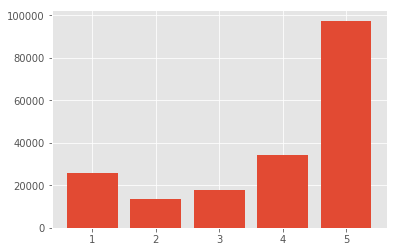


Number of unique business_id (restaurant): 
4249

Number of unique user_id (user)
102800


In [12]:
# Get business_id, user_id, stars for recommender
df_stars = df[['business_id', 'user_id', 'stars']]

print ("Distribution of ratings: ")
plt.bar(df_stars['stars'].value_counts().index, df_stars['stars'].value_counts().values)
plt.show()
print ()

print ("Number of unique business_id (restaurant): ")
print (df_stars['business_id'].nunique())
print ()

print ("Number of unique user_id (user)")
print (df_stars['user_id'].nunique())

We might easily find that many users give only 1 or 2 reviews. We should exclude these users from our data, since it has little information as well as reduces the efficiency of algorithm. 

Let's assume an active user is the one who comments over 5 times. 

In [13]:
df_user_counts = df_stars['user_id'].value_counts()

print ("%d users only comment once." %df_user_counts[df_user_counts == 1].sum())

df_users = df_user_counts[df_user_counts > 5]

print ("After filtering, we only have %d users." %df_users.count())
print ("Total number of comments is: %d"%df_users.sum())

# filter the rating table
df_stars_cleaned = df_stars.set_index('user_id').loc[df_users.index,:].reset_index()

71200 users only comment once.
After filtering, we only have 4133 users.
Total number of comments is: 44701


### Similarity Matrix

To get a similarity matrix, first we need to generate an utility matrix, in which the value is rating score, index is user id and column is business id. We can use `pd.pivot_table` to implement this transformation.

Then, we use `sklearn.metrics.pairwise.cosine_similarity` to compute similarity matrix. Please note that this is item-item collaborative filtering, thus dimension of similarity matrix should be equal to number of restaurants.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# convert to document, word like matrix
df_utility = pd.pivot_table(data=df_stars_cleaned,
                            values='stars', # fill with stars
                            index='user_id', # rows
                            columns='business_id', # columns
                            fill_value=0) # fill missings

# Item-Item Similarity Matrix
item_sim_mat = cosine_similarity(df_utility.T)

In [15]:
# check for similarity dimension
assert item_sim_mat.shape[0] == df_stars_cleaned['business_id'].nunique()

### Prediction

To make prediction for a user, we need to find nearest neighborhood in order to compute weighted average score. Let's first find the indexes of nearest neighborhood.

In [16]:
# argsort to get the index of sorted similarity
least_to_most_sim_indexes = np.argsort(item_sim_mat, axis=1)

# number of neighborhoods (hyperparameters)
neighborhood_size = 75
neighborhoods = least_to_most_sim_indexes[:, -neighborhood_size-1:-1] # remove the last one, since it is itself!

Now we are ready to make prediction, give a user. Let's pick a lucky user `'qKUEhJUl0Z9MFW7R7BTvRQ'`. 

* First, we need to find the items that are rated by this user. 
* For each item $i$ to be rated, 
    * Find the nearest neighbors of this item $N_i$, then intersect with the items rated by this user $I_u$.
    * The predicted rating is the weighter average, $$rating(u,i) = \frac{\sum_{j\in N_i \cap I_u} similarity(i,j) * r_{u,j}}{\sum_{j\in N_i \cap I_u} similarity(i,j)}$$
    * $similarity(i,j)$ is the similarity between item $i$ and $j$, $r_{u,j}$ is the rating user $u$ gives item $j$.

In [17]:
# pick a lucky user
user_id = 'qKUEhJUl0Z9MFW7R7BTvRQ'

n_users = df_utility.shape[0]
n_items = df_utility.shape[1]

items_rated_by_this_user = df_utility.loc[user_id,:].values.nonzero()[0]
# Just initializing so we have somewhere to put rating preds
out = np.zeros(n_items)
for item_to_rate in range(n_items):
    relevant_items_idx = np.intersect1d(neighborhoods[item_to_rate],
                                    items_rated_by_this_user,
                                    assume_unique=True)  # assume_unique speeds up intersection op
    relevant_items = df_utility.columns[relevant_items_idx].values
    out[item_to_rate] = df_utility.loc[user_id, relevant_items].values.dot(
        item_sim_mat[item_to_rate, relevant_items_idx].T) / item_sim_mat[item_to_rate, relevant_items_idx].sum()

pred_ratings = np.nan_to_num(out)
print (pred_ratings)

[3.4606816 1.        1.        ... 5.        5.        1.       ]


### Final Recommendations

Now we make our final recommendation, based on the predicted rating in the previous section. Top 10 restaurants are recommended in the end.

In [18]:
# Hyperparameter: Recommend n movies
n = 10

# Get item indexes sorted by predicted rating
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))

# Find items that have been rated by user
item_index_rated_by_this_user = df_utility.loc[user_id,:].values.nonzero()[0]

# We want to exclude the items that have been rated by user
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in item_index_rated_by_this_user]

df_utility.columns[unrated_items_by_pred_rating[-n:]].values

array(['PM0A7ZgbxvtbRCj931PbyQ', 'h4Q-uSoOIhMoIsOhat6l3A',
       'J1MVP1oGbBnKVqriX4HDuQ', '0_VT3sTwi7gorIlU36ASmg',
       'jSu2A7DibDjmUd3wUt6fPg', '0Myf2fOlXXNHgIuPZoOlsA',
       'oE-vW0S6wRh0YVki7_pVBA', '4yJVSK-Q5UkED6RjORRssA',
       'cjlYcqxyqRBe_w3OgasPAw', 'XtE_J8DZXgjFbW1xVkqmUw'], dtype=object)

### Evaluation

To evaluate our recommender system, we should compare the predicted rating to the true rating in our dataset. Let's only evaluate this single user, though in reality all user should be predicted and evaluated.

In [25]:
# get item id that is rated by this user
item_rated_by_this_user = df_utility.columns[item_index_rated_by_this_user].values

# prediction rating score
y_pred = pred_ratings[item_index_rated_by_this_user]

# true rating score
y_true = df_utility.loc[user_id, item_rated_by_this_user].values

# RMSE
print ("RMSE: ", np.sqrt(np.mean((y_pred - y_true)**2)))

# MAE
print ("MAE: ", np.mean(np.abs(y_pred - y_true)))

RMSE:  1.5547033931153946
MAE:  1.261639772554199


A RMSE of 1.55 and MAE of 1.26 are derived for this user. You might try other users by changing the `user_id`. The result is fine, but not that good. The high mean absolute error indicates that a predicted rating of say 4.5, may roughly vary between 3.14 to 5.0. This may lead to the true situation of not recommendation, but we actually recommend this item (4.5>4). 

Tuning hyperparameter `number of neighborhood` may improve the performance, but let's try model-based recommender system using `surprise` package.

## Model-based Recommender

[Surprise](https://surprise.readthedocs.io/en/stable/index.html) is an easy-to-use Python scikit for recommender systems. It has a lot of builtin datasets that you can play with. Alternatively, you can of course use a custom dataset as well. You should load a rating matrix from csv file or from a pandas dataframe. Either way, you will need to define a `Reader` object for `Surprise` to be able to parse the file or dataframe.

To load a dataset from a pandas dataframe, you will need the `load_from_df()` method. You will also need a `Reader` object, but only the `rating_scale` parameter must be specified. The dataframe must have three columns, corresponding to the **user (raw) ids**, the **item (raw) ids**, and **the ratings** in this order.

In [20]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_stars[['user_id', 'business_id', 'stars']], reader)

Now we turn the dataframe into `surprise.Dataset`. Let's apply SVD, NMF, SVDpp, KNNBasic to our dataset. To better visualize the results, we create a dictionary that maps algorithm names to reference links. We will also be using cross validation to train model and get average RMSE and MAE on validation set. It may run up to 5 minutes. 

In [22]:
from __future__ import (absolute_import, division, print_function,unicode_literals)

from surprise import KNNBasic, SVD, SVDpp, NMF
from surprise.model_selection import KFold
from tabulate import tabulate
import time
import datetime
import six

classes = (SVD, SVDpp, NMF)
# dict to map algo names and datasets to their markdown links in the table
stable = 'http://surprise.readthedocs.io/en/stable/'
LINK = {'SVD': '[{}]({})'.format('SVD',
                                 stable +
                                 'matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD'),
        'SVDpp': '[{}]({})'.format('SVD++',
                                   stable +
                                   'matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp'),
        'NMF': '[{}]({})'.format('NMF',
                                 stable +
                                 'matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF'),
        'Yelp Dataset': '[{}]({})'.format('Yelp Dataset',
                                     'https://www.yelp.com/dataset')
        }
# set seed
np.random.seed(42)
# folds will be the same for all algorithms.
kf = KFold(random_state=42)  

In [24]:
table = []
for klass in classes:
    start = time.time()
    out = cross_validate(klass(), data, ['rmse', 'mae'], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    link = LINK[klass.__name__]
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse']))
    mean_mae = '{:.3f}'.format(np.mean(out['test_mae']))

    new_line = [link, mean_rmse, mean_mae, cv_time]
#     print(tabulate([new_line], tablefmt="pipe"))
    table.append(new_line)

header = [LINK['Yelp Dataset'],'RMSE','MAE','Time']
print(tabulate(table, header, tablefmt="pipe"))

| [Yelp Dataset](https://www.yelp.com/dataset)                                                                                          |   RMSE |   MAE | Time    |
|:--------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|:--------|
| [SVD](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)     |  1.314 | 1.057 | 0:00:40 |
| [SVD++](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp) |  1.339 | 1.083 | 0:01:44 |
| [NMF](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF)     |  1.527 | 1.23  | 0:01:09 |


| [Yelp Dataset](https://www.yelp.com/dataset)                                                                                          |   RMSE |   MAE | Time    |
|:--------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|:--------|
| [SVD](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)     |  1.314 | 1.057 | 0:00:40 |
| [SVD++](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp) |  1.339 | 1.083 | 0:01:44 |
| [NMF](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF)     |  1.527 | 1.23  | 0:01:09 |

As we can see, SVD gets best result, with 1.314 RMSE and 1.057 MAE. In this situation, model-based CF is better than Memory-based CF. However, both of them suffer two major challenges: data sparsity and scalability. A hybrid method combining memory-based and model-based can overcome these problems. We will give a brief introduction of Hybrid Recommender in the next section.

## Hybrid Recommender

A [Hybrid](https://en.wikipedia.org/wiki/Collaborative_filtering#Hybrid) method overcome the limitations of traditional CF approaches and improve prediction performance. However, they have increased complexity and are expensive to implement. 

In [Hybrid User-Item Based Collaborative Filtering](https://reader.elsevier.com/reader/sd/pii/S1877050915023492?token=494AE625B6CDBE7BCCC5E9D2AA0C20D95BED53871AF0211228E6EA4E9609E5549FDE39ED618C34E7F2F3ADDBE6FE4FBA), the authors proposed a hybrid method based on item-item CF. 
* Case Based Reasoning with averaging filing is used to handle sparsity problem. 
* Self-Organizing Map (SOM) optimized with Genetic Algorithm (GA) performs user clustering in large datasets to reduce the scope. 

In 2007, Google also gives a scalable online CF method, in order to solve large and dynamic settings problem. In [Google News Personalization: Scalable Online Collaborative Filtering](https://www2007.org/papers/paper570.pdf), they generate recommendations for google news by three approaches.
* collaborative filtering using MinHash clustering (Jaccard coefficient)
* Probabilistic Latent Semantic Indexing (PLSI): The relationship between users and items is learned by modeling the joint distribution of users and items as a mixture distribution
* covisitation counts: covisitation is defined as an event in which two stories are clicked by the same user within a certain time interval (typically set to a few hours).

Then they combine recommendations from different algorithms using a linear model (like stacking). 

The recommender system is very personalized for different companies with different products. For example, in the content of Google News Recommender, the rating is binary. A click on a story corresponds to a 1 rating, while a non-click corresponds to a 0 rating. In the content of movie or restaurant recommender, however, the rating scale is 1 to 5. 

In addition, this article [Collaboration via Content](http://recommender-systems.org/hybrid-recommender-systems) compared the collaboration with content. A hybrid method can also be the combination of content-based and CF. 